In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm
import seaborn as sns
import itertools
import ipywidgets as ipw

# Variable definition
lcaDataPath = "C:/Users\lukec\OneDrive - University of Cambridge\Projects\PhD\Data\EcoInvent_B0729/xml"
impactMethods = "C:/Users\lukec\OneDrive - University of Cambridge\Projects\PhD\Data\Impact-Methods\IPCC2013.xml"

In [2]:
# Ensure element is a list of lists even if single inner list
def to_listlist(inlist:list): return [inlist] if type(inlist[0]) is str else inlist

# Read in impact factors
def read_xml_attributes(filepath:str,branches:list,attributes:list,df=False):
    """This function creates a dataframe of attributes within an xml file.\n
    Inputs:\n
    filepath - path to xml file\n
    branches - list of successive branch choices\n
    attributes - attributes to be read from chosen branch\n
    Outputs:\n
    df - pandas dataframe of attributes for each end branch\n
    Requirements: pandas as pd, xml.etree.ElementTree as ET"""
    if df is False: df = pd.DataFrame([],columns=attributes)
    tree_loc = ET.parse(filepath).getroot()
    branches, attributes = to_listlist(branches), to_listlist(attributes)
    attr_values = dict()
    for pathnum, path in enumerate(branches):
        for branch in path:
            for num,val in enumerate([branch in i.tag for i in tree_loc]):
                if val:
                    if branch is path[-1]:
                        attr_values.update(dict(zip(attributes[pathnum],[tree_loc[num].attrib[i] for i in attributes[pathnum]])))
                        if path is branches[-1]: df = df.append(attr_values,ignore_index=True)
                    else:
                        tree_loc=tree_loc[num]
                        break
    return df

In [3]:
# Fetch and display impact factors
impacts = read_xml_attributes(impactMethods,['dataset','flowData','exchange'],['name','category','subCategory','meanValue'])
impacts.sort_values('name')

,name,category,subCategory,meanValue
56,"Carbon dioxide, fossil",Emission to air,unspecified,1.0
45,"Carbon dioxide, fossil",Emission to air,low population density,1.0
164,"Carbon dioxide, fossil",Emission to air,"low population density, long-term",1.0
69,"Carbon dioxide, fossil",Emission to air,lower stratosphere + upper troposphere,1.0
19,"Carbon dioxide, fossil",Emission to air,high population density,1.0
...,...,...,...,...
189,Sulfur hexafluoride,Emission to air,lower stratosphere + upper troposphere,23506.81999316
79,Sulfur hexafluoride,Emission to air,"low population density, long-term",23506.81999316
44,Sulfur hexafluoride,Emission to air,low population density,23506.81999316
3,Sulfur hexafluoride,Emission to air,unspecified,23506.81999316


In [ ]:
# Load in xml data to dataframe
def calculate_co2e(filepath:str, lookup:pd.DataFrame, branches:list=None, attributes:list=None):
    """This function calculates total CO2e impacts for processes given the outputs and impact factors\n
    Inputs:\n
    filepath - path to process xml file\n
    lookup - dataframe with CO2e values for a unit of output materials\n
    branches - branches for outputs in xml file\n
    attributes - attributes at destination branch in xml file\n
    Output: Float of total CO2e due to process.\n
    Requirements: pandas as pd, read_xml_attributes function"""
    # Defaults
    if attributes is None: attributes = ['name', 'category', 'subCategory', 'meanValue']
    if branches is None: branches = ['dataset', 'flowData', 'exchange']
    # Calculation
    product = read_xml_attributes(filepath,branches,attributes)
    product = product.rename(columns={attributes[-1]: "kg"})
    emissions = product.merge(lookup)
    return sum(pd.to_numeric(emissions['kg'])*pd.to_numeric(emissions[attributes[-1]]))

def import_xml_batch(directory:str,path:list,attributes:list,co2e=False,impacts=False):
    """This function imports xml data into a pandas dataframe inputs:\n
    directory - directory of xml files\n
    path - location of attributes within xml\n
    attributes - names of attributes/column names\n
    outputs:\n
    df - dataframe of requested attributes\n
    Requirements: os, pandas as pd, xml.etree.ElementTree as ET"""
    file_list = os.listdir(directory)
    attributes = to_listlist(attributes)
    df = pd.DataFrame([],columns=[j for i in attributes for j in i])
    if co2e is not False: df[co2e] = None
    for file in tqdm(file_list):
        df = read_xml_attributes(os.path.join(directory, file),path,attributes,df)
        if co2e is not False: df[co2e].iloc[-1] = calculate_co2e(os.path.join(directory, file), impacts)
    return df, file_list

processes, _ = import_xml_batch(lcaDataPath,[['dataset','meta','process','reference'],['dataset','meta','process','geo']],[['name','generalComment'],['location']],'CO2e',impacts)

In [4]:
# Save or load processes file
processes_file = "C:/Users\lukec\OneDrive - University of Cambridge\Projects\PhD\Data\EcoInvent_B0729\process_co2e/GWP100a_IPCC2013.csv"
if 'processes' in locals(): processes.sort_values('name').to_csv(processes_file)
else: processes = pd.read_csv(processes_file,index_col=0)

In [5]:
# Filter dataframe for non market activities
production = processes[~ processes['generalComment'].str.contains('market')].sort_values('name')

In [6]:
# Default product components
product_name="Luke's machine"
components = ['gold','barite','copper concentrate, sulfide ore','iron ore concentrate']
quantity = [0.01,100,100,90]
plot_props = {'style':'white','font_scale':1.5,'cmap':plt.cm.get_cmap('tab10').colors}

In [7]:
# Define function to plot footprint distribution according to components
sns.set_theme(style=plot_props['style'], font_scale=plot_props['font_scale'])

def get_footprint_dist(components:list,quantity:list,data:pd.DataFrame,provenance:list=False,name_col:str='name',plot:bool=True,
                       plot_props:dict=None,product_name:str='Product'):
    """This function outputs the distribution of possible emissions due to a product according to its composition\n
    Inputs:\n
    components - list of product components\n
    quantity - quantity in kg of eah product\n
    data - dataframe containing emissions due to components\n
    name_col - column name for components in dataframe\n
    plot - True outputs distribution plot\n
    Outputs:\n
    emission_dist - dataframe of rows with emissions for each possible pathway\n
    plot - distribution plot with emissions according to each component"""
    # Get database of process emissions according to components
    proc_emissions = data.copy()[[i in components for i in data[name_col]]]
    if provenance:
        proc_emissions = proc_emissions.iloc[np.where(sum([np.logical_and(proc_emissions[name_col]==components[i], [k in prov for k in proc_emissions.location]) if 'Unknown' not in prov else proc_emissions[name_col]==components[i] for i, prov in enumerate(provenance)]))[0]]
    proc_emissions.CO2e = proc_emissions.CO2e*[quantity[i] for i in [components.index(i) for i in proc_emissions[name_col]]]

    # Find all possible supply chains
    num_comps = len(components)
    combinations = [proc_emissions[name_col][i] for i in [list(i) for i in list(itertools.combinations(proc_emissions.index, num_comps))]]
    chains = [combinations[i] for i in np.where([len(set(i)) == num_comps for i in combinations])[0]]

    # Get emissions for all possible supply chains
    emission_dist = pd.DataFrame(np.asarray([proc_emissions.loc[i.index].CO2e for i in chains]),columns=np.sort(components))
    emission_dist['Total']=emission_dist.sum(axis=1)
    if plot:
        # Default + update variables
        rcps = {'cmap': plt.cm.get_cmap('tab10').colors, 'kind':'kde', 'fill':True, 'cut':0, 'log_scale':[False,True], 'height':7, 'aspect':1.5, 'alpha':0.65, 'title':product_name+' CO2e footprint\n'+'Mean: '+str(round(emission_dist['Total'].mean(),2))+'t Stdev: '+str(round(emission_dist['Total'].std(),2))+'t','xlabel':'Emissions (t CO2e)', 'ylabel':'Probability'}
        if plot_props: rcps.update(plot_props)
        # Plot distributions
        sns.displot(emission_dist, kind=rcps['kind'], fill=rcps['fill'], hue_order=np.flip(emission_dist.columns), cut=rcps['cut'], log_scale=rcps['log_scale'], height=rcps['height'], aspect=rcps['aspect'], alpha=rcps['alpha'], warn_singular=False).set(title=rcps['title'],xlabel=rcps['xlabel'], ylabel=rcps['ylabel'])
        # Plot single lines for collapsed distributions
        lines = np.flip([emission_dist[i].unique()[0] if len(emission_dist[i].unique())==1 else 0 for i in emission_dist.columns])
        plt.vlines(lines,color=rcps['cmap'][:len(emission_dist.columns)], ymin=0, ymax=1, alpha=[i>0 for i in lines])
        plt.show()
    return emission_dist

In [8]:
# Define components
components_wg = ipw.SelectMultiple(options=production.name.unique(),value=components,rows=10,description='Components', disabled=False)
display(components_wg)

SelectMultiple(description='Components', index=(13, 0, 7, 19), options=('barite', 'bauxite', 'bulk lead-zinc c…

In [9]:
# Set quantities and provenance of components
quantity_wg = ipw.HBox([ipw.FloatLogSlider(value=quantity[num], description=i, base=10, min=-3, max=4, step=0.01, disabled=False) for num,i in enumerate(list(components_wg.value))])
provenance_wg = ipw.HBox([ipw.SelectMultiple(options=['Unknown']+list(production[production.name==j].location.values), description=j, value=['Unknown']) for j in list(components_wg.value)])
display(ipw.VBox([quantity_wg,provenance_wg]))

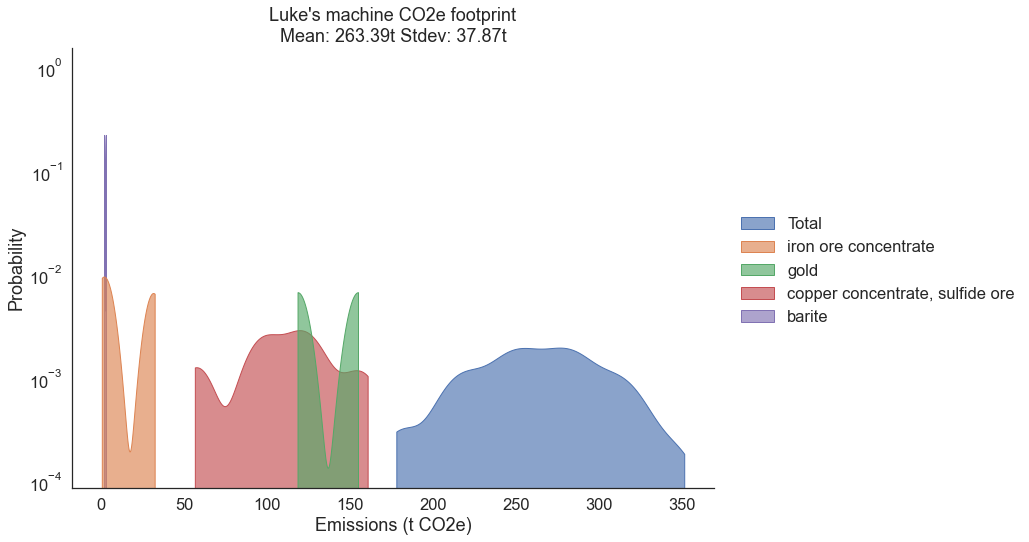

In [11]:
# Output footprint distributions for chosen product composition
emission_dist = get_footprint_dist(list(components_wg.value),list(map(lambda i: i.value, quantity_wg.children)),production,
                       provenance=list(map(lambda i: list(i.value), provenance_wg.children)), product_name=product_name)

In [224]:
# button = ipw.Button(description='Calculate')#, disabled=False, button_style='success', tooltip='Confirm', icon='check')
# out = ipw.Output()
# def on_button_clicked(b):
#     button.description = 'clicked'
#     with out:
#         print(1+1)
#         # _ = get_footprint_dist(list(components_wg.value),[i.value for i in quantity_wg.children],production,provenance = [j.value for j in provenance_wg.children])
# button.on_click(on_button_clicked)
# ipw.VBox([button, out])

In [ ]:
# Get data from all files into database

In [ ]:
# Graph it up baby